In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
%reload_ext autoreload
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cftime
import os
import ml_downscaling_emulator.helpers as helpers

In [5]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [6]:
hi_res_dataset = xr.open_mfdataset(helpers.data_filepath("2.2km", "london", "cpm", "pr", 1980)).rename({'pr': 'target_pr', 'ensemble_member_id': 'cpm_ensemble_member_id'})

In [7]:
sorted_time = np.flipud(hi_res_dataset.isel(ensemble_member=0).sum(dim=['grid_latitude', 'grid_longitude']).sortby('target_pr').time.values.copy())

In [8]:
import datetime
window_half_size = 5
print(sorted_time[0])
times = np.arange(sorted_time[0] - datetime.timedelta(days = window_half_size), sorted_time[0] + datetime.timedelta(days = window_half_size+1), datetime.timedelta(days = 1), dtype=type(sorted_time[0]))
print(times)
times2 = np.arange(sorted_time[1] - datetime.timedelta(days = window_half_size), sorted_time[1] + datetime.timedelta(days = window_half_size+1), datetime.timedelta(days = 1), dtype=type(sorted_time[1]))
times3 = np.arange(sorted_time[1] - datetime.timedelta(days = 6), sorted_time[1] + datetime.timedelta(days = 7), datetime.timedelta(days = 1), dtype=type(sorted_time[1]))
#(sorted_time[0] datetime.timedelta(days = 2)

1981-11-20 12:00:00
[cftime.Datetime360Day(1981, 11, 15, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 16, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 17, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 18, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 19, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 20, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 21, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 22, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 23, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 24, 12, 0, 0, 0)
 cftime.Datetime360Day(1981, 11, 25, 12, 0, 0, 0)]


In [9]:
test_times = set()
test_times.update(times)
test_times.update(times2)
val_times = set()
val_times.update(times3)
train_times = set(sorted_time)  - test_times - val_times

In [10]:

hi_res_dataset.where(hi_res_dataset.time.isin(list(test_times)) == True, drop=True)

<xarray.Dataset>
Dimensions:                     (bnds: 2, ensemble_member: 1, grid_latitude: 53, grid_longitude: 53, time: 22)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1981-01-21 12:00:00 ... 1981-11...
  * grid_latitude               (grid_latitude) float64 -1.5 -1.48 ... -0.46
  * grid_longitude              (grid_longitude) float64 361.1 361.1 ... 362.1
    cpm_ensemble_member_id      (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude                    (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
    longitude                   (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(22,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(22,), meta=np.ndarray>
    yyyymmdd                    (time) |S64 dask.array<chunksize=(22,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    target_pr                   (ensemble_member, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 22, 53, 53), meta=np.ndarray>
    rotated_latitude_longitude  (time) float64 -2.147e+09 ... -2.147e+09
    time_bnds                   (time, bnds) object dask.array<chunksize=(22, 2), meta=np.ndarray>
    grid_latitude_bnds          (grid_latitude, bnds, time) float64 dask.array<chunksize=(53, 2, 22), meta=np.ndarray>
    grid_longitude_bnds         (grid_longitude, bnds, time) float64 dask.array<chunksize=(53, 2, 22), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [11]:
len(train_times)

336

In [12]:
train_set = xr.open_dataset("../../../../derived_data/nc-datasets/2.2km-coarsened-2x_london_pr_intensity/train.nc")
val_set = xr.open_dataset("../../../../derived_data/nc-datasets/2.2km-coarsened-2x_london_pr_intensity/val.nc")
test_set = xr.open_dataset("../../../../derived_data/nc-datasets/2.2km-coarsened-2x_london_pr_intensity/test.nc")

In [21]:
test_set.time.values

array([cftime.Datetime360Day(1981, 1, 21, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 22, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 23, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 24, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 25, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 26, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 27, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 28, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 29, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 1, 30, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 2, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 18, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 19, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 20, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 21, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 22, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 23, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 3, 24, 12, 0, 

(array([8.64199e+05, 1.02595e+05, 3.35560e+04, 7.88800e+03, 1.80500e+03,
        6.56000e+02, 2.77000e+02, 1.32000e+02, 4.80000e+01, 8.40000e+01]),
 array([  0.      ,  12.253441,  24.506882,  36.760323,  49.013763,
         61.267204,  73.520645,  85.774086,  98.02753 , 110.28097 ,
        122.53441 ], dtype=float32),
 <BarContainer object of 10 artists>)

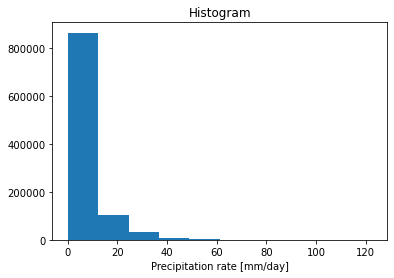

In [14]:
test_set.pr.plot.hist()

In [15]:
ssi_train_set = xr.open_dataset("../../../../derived_data/nc-datasets/2.2km-coarsened-2x_london_pr_ssi/train.nc")
ssi_val_set = xr.open_dataset("../../../../derived_data/nc-datasets/2.2km-coarsened-2x_london_pr_ssi/val.nc")
ssi_test_set = xr.open_dataset("../../../../derived_data/nc-datasets/2.2km-coarsened-2x_london_pr_ssi/test.nc")

In [32]:
ssi_test_set.groupby("season")[2].time

<xarray.DataArray 'time' (time: 97)>
array([cftime.Datetime360Day(1981, 6, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 2, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 3, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 4, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 5, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 6, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 7, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 8, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 9, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 10, 12, 0, 0, 0),
       cftime.Datetime360Day(1981, 6, 11, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 2, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 3, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 4, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 5, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 6, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 7, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 8, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 9, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 19, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 20, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 21, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 22, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 23, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 24, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 25, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 26, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 27, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 28, 12, 0, 0, 0),
       cftime.Datetime360Day(1982, 6, 29, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 17, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 18, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 19, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 20, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 21, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 22, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 23, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 24, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 25, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 26, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 27, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 28, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 29, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 6, 30, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 2, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 3, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 4, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 5, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 6, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 7, 12, 0, 0, 0),
       cftime.Datetime360Day(1984, 7, 8, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 2, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 3, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 4, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 5, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 6, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 7, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 8, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 9, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 10, 12, 0, 0, 0),
       cftime.Datetime360Day(1985, 6, 11, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 12, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 13, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 14, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 15, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 16, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 17, 12, 0, 0, 0),
       cftime.Datetime360Day(1986, 6, 18, 12, 0, 0, 0),
       cftime.Datetime

(array([9.59263e+05, 1.09912e+05, 3.45260e+04, 8.22500e+03, 2.00900e+03,
        6.97000e+02, 2.77000e+02, 1.32000e+02, 4.80000e+01, 8.40000e+01]),
 array([  0.      ,  12.253441,  24.506882,  36.760323,  49.013763,
         61.267204,  73.520645,  85.774086,  98.02753 , 110.28097 ,
        122.53441 ], dtype=float32),
 <BarContainer object of 10 artists>)

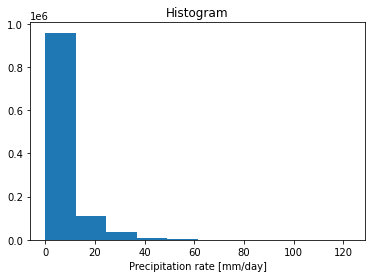

In [17]:
ssi_test_set.pr.plot.hist()